In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [2]:
heart_disease_dataset = pd.read_csv('./heart.csv')
heart_disease_dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
# Prepare data.
heart_X = heart_disease_dataset.loc[:,'age':'thal']
heart_Y = heart_disease_dataset.loc[:,'target']
heart_X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [4]:
heart_X = heart_X.values
print(len(heart_X))
heart_X

303


array([[63.,  1.,  3., ...,  0.,  0.,  1.],
       [37.,  1.,  2., ...,  0.,  0.,  2.],
       [41.,  0.,  1., ...,  2.,  0.,  2.],
       ...,
       [68.,  1.,  0., ...,  1.,  2.,  3.],
       [57.,  1.,  0., ...,  1.,  1.,  3.],
       [57.,  0.,  1., ...,  1.,  1.,  2.]])

In [5]:
heart_X.shape

(303, 13)

In [6]:
print(type(heart_Y))
heart_Y.values

<class 'pandas.core.series.Series'>


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [7]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
threshold_acc = 0.87

In [8]:
def fit_model(X,Y,model,epochs_val,batch_size_val,verbose_val=False):
    history = model.fit(X,Y,epochs=epochs_val,batch_size=batch_size_val,verbose=verbose_val)
    acc_values = history.history['acc']
    print("Accuracy Stats: %.2f (%.2f)" % (results.mean()*100, results.std()*100))

In [9]:
class ModelConfig(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if logs['acc'] <= threshold_acc:
            print("\nReached 87% accuracy so cancelling training!\n")
            self.model.stop_training = True
model_callback = ModelConfig()            

## Baseline Model.

In [10]:
def baseline_model():
    model = Sequential()
    model.add(Dense(13,input_dim=13,activation='relu'))
    model.add(Dense(13,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    # Compile.
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return model

In [11]:
estimator = KerasClassifier(build_fn=baseline_model,epochs=100,batch_size=5,verbose=False)
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=seed)
results = cross_val_score(estimator,heart_X,y=heart_Y,cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Standardized: 80.86% (6.35%)


In [12]:
# Data Preparation using Sicket Learn Standardization.
estimators = []
estimators.append(('standardize',StandardScaler()))
estimators.append(('mlp',KerasClassifier(build_fn=baseline_model,epochs=100,batch_size=5,verbose=False)))
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=seed)
pipeline = Pipeline(estimators)
results = cross_val_score(pipeline,heart_X,y=heart_Y,cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized: 78.56% (4.71%)


## Smaller Model

In [13]:
def smaller_model():
    model = Sequential()
    model.add(Dense(13,input_dim=13,activation='relu'))
    model.add(Dense(6,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    # Compile.
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return model

In [14]:
estimators = []
estimators.append(('standardize',StandardScaler()))
estimators.append(('mlp',KerasClassifier(build_fn=smaller_model,epochs=100,batch_size=5,verbose=False)))
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=seed)
pipeline = Pipeline(estimators)
results = cross_val_score(pipeline,heart_X,y=heart_Y,cv=kfold)
print("Smaller Network Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Smaller Network Standardized: 80.84% (6.31%)


## Larger Model

In [15]:
def larger_model():
    model = Sequential()
    model.add(Dense(13,input_dim=13,activation='relu'))
    model.add(Dense(13,activation='relu'))
    model.add(Dense(6,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    # Compile.
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return model

In [16]:
estimators = []
estimators.append(('standardize',StandardScaler()))
estimators.append(('mlp',KerasClassifier(build_fn=larger_model,epochs=100,batch_size=5,verbose=False)))
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=seed)
pipeline = Pipeline(estimators)
results = cross_val_score(pipeline,heart_X,y=heart_Y,cv=kfold)
print("Larger Network Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger Network Standardized: 81.18% (7.11%)


## Overfitting the Model.

In [17]:
def create_overfit_model():
    model = Sequential()
    model.add(Dense(13,input_dim=13,activation='relu'))
    model.add(Dense(26,activation='relu'))
    model.add(Dense(13,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    # Compile.
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return model

In [18]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp',KerasClassifier(build_fn=create_overfit_model,epochs=150,batch_size=5, verbose=0)))
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=seed)
pipeline = Pipeline(estimators)
results = cross_val_score(pipeline,heart_X,y=heart_Y,cv=kfold)
print("Overfit Network Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Overfit Network Standardized: 79.49% (7.48%)


In [19]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
skf = StratifiedKFold(n_splits=2)
print("Number of splits.")
print(skf.get_n_splits(X, y))
print(skf)
StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
print()
print("Train Set")
print(X_train)
print()
print("Test Set")
print(X_test)
    

Number of splits.
2
StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
TRAIN: [1 3] TEST: [0 2]
TRAIN: [0 2] TEST: [1 3]

Train Set
[[1 2]
 [1 2]]

Test Set
[[3 4]
 [3 4]]


## Tuning Model

In [20]:
class MyModel(tf.keras.Model):
     def __init__(self):
        super(MyModel,self).__init__()
        self.dense1 = Dense(13,activation='relu')
        self.dense2 = Dense(13,activation='relu')
        self.dense3 = Dense(1,activation='sigmoid')
    
     def call(self,inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

In [21]:
def get_class_model():
    inputs = tf.keras.Input(shape=(13,))
    mymodel = MyModel()
    outputs = mymodel.call(inputs)
    # Keras Model.
    model = tf.keras.Model(inputs,outputs)
    # Compile.
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return model

my_model = get_class_model()
history = my_model.fit(heart_X,heart_Y,epochs=100,batch_size=5,verbose=False)
acc_values = history.history['acc']
print("Accuracy Stats: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy Stats: 79.49% (7.48%)


In [22]:
fit_model(heart_X,heart_Y,get_class_model(),120,5)

Accuracy Stats: 79.49 (7.48)


In [23]:
# Tuning Model.
def create_tuned_model():
    model = Sequential()
    model.add(Dense(13,input_dim=13,activation='relu'))
    model.add(Dense(13,activation='relu'))
    model.add(Dense(13,activation='relu')) ## Added hidded layer.
    model.add(Dense(1,activation='sigmoid'))
    # Compile.
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return model

In [24]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_tuned_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, heart_X, heart_Y, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 78.83% (7.87%)


## Keras Functional API

In [25]:
def functional_model():
    inputs = tf.keras.Input(shape=(13,))
    x = Dense(13, activation='relu')(inputs)
    x = Dense(13, activation='relu')(x)
    x = Dense(13, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    # Compile.
    model = tf.keras.Model(inputs,output)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
    return model

In [26]:
model = functional_model()
history = model.fit(heart_X,heart_Y,batch_size=5,epochs=100,verbose=0)
history_dict = history.history
all_acc_scores = history_dict['acc']
print("Accuracy: Mean %.2f%% and Standard Deviation %.2f%%" %(np.mean(all_acc_scores)*100, np.std(all_acc_scores)*100))

Accuracy: Mean 78.77% and Standard Deviation 5.73%


In [27]:
# plt.hist(np.concatenate(history_dict['acc'],history_dict['loss']).cumsum(),bins=2)

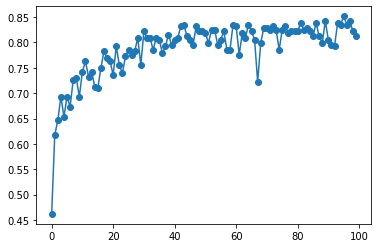

In [28]:
plt.plot(history_dict['acc'],marker='o')

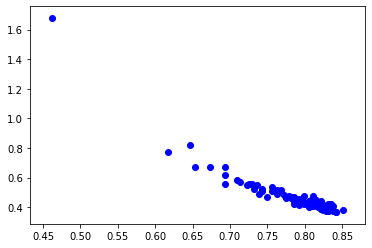

In [29]:
# print(history_dict['loss']*100)
plt.scatter(history_dict['acc'],history_dict['loss'], color='b')

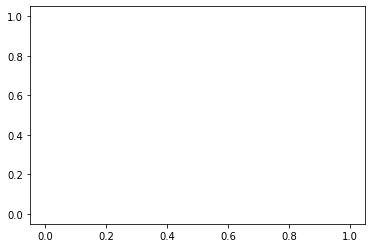

In [30]:
plt.scatter(np.random.randn(0,1),np.random.rand(0,1), color='b')

(array([ 1.,  0.,  0.,  1.,  2.,  4.,  6., 11., 36., 39.]),
 array([0.4620462 , 0.5009901 , 0.539934  , 0.57887787, 0.61782175,
        0.6567657 , 0.6957096 , 0.7346535 , 0.77359736, 0.81254125,
        0.85148513], dtype=float32),
 <a list of 10 Patch objects>)

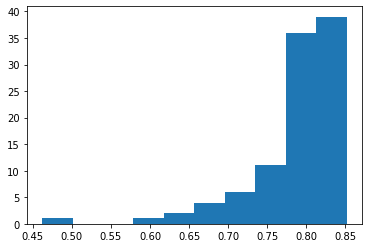

In [31]:
plt.hist(history_dict['acc'])

## Model Subclassing.

In [32]:
# On epoch end.
class Model_Config(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if logs.get("acc") >= 0.85:
            print("Accuracy exceeded 85%")
            self.model.stop_training = True
model_callbacks = Model_Config()                        

In [33]:
class HeartModel(tf.keras.Model):
    def __init__(self):
        super(tf.keras.Model).__init__()
        self.dense1 = Dense(13, activation='relu')
        self.dense2 = Dense(13, activation='relu')
        self.dense3 = Dense(13, activation='relu')
        self.dense4 = Dense(1, activation='sigmoid')
   
    def call(self,inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dense4(x)
    
def subclassed_heart_model(model_class):
    inputs = tf.keras.Input(shape=(13,))
    mymodel = MyModel()
    outputs = mymodel.call(inputs)
    # Keras Model.
    model = tf.keras.Model(inputs,outputs)
    # Compile.
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return model

model = subclassed_heart_model(HeartModel)
model.fit(heart_X,heart_Y,epochs=100,batch_size=5,callbacks=[model_callbacks])

Train on 303 samples
Epoch 1/100
303/303 [==============================] - 1s 4ms/sample - loss: 20.5294 - acc: 0.5446
Epoch 2/100
303/303 [==============================] - 0s 726us/sample - loss: 1.4993 - acc: 0.5908
Epoch 3/100
303/303 [==============================] - 0s 714us/sample - loss: 0.8098 - acc: 0.5809
Epoch 4/100
303/303 [==============================] - 0s 699us/sample - loss: 0.6496 - acc: 0.6337
Epoch 5/100
303/303 [==============================] - 0s 731us/sample - loss: 0.6271 - acc: 0.6700
Epoch 6/100
303/303 [==============================] - 0s 693us/sample - loss: 0.6447 - acc: 0.6403
Epoch 7/100
303/303 [==============================] - 0s 717us/sample - loss: 0.6204 - acc: 0.6502
Epoch 8/100
303/303 [==============================] - 0s 706us/sample - loss: 0.6112 - acc: 0.6403
Epoch 9/100
303/303 [==============================] - 0s 716us/sample - loss: 0.6156 - acc: 0.6601
Epoch 10/100
303/303 [==============================] - 0s 719us/sample - loss: 

## K-Fold Cross Validation

In [47]:
k = 10
number_of_samples = len(heart_X) // k
number_of_epochs = 100
print("Number of Samples: {}".format(number_of_samples))
#
np.random.shuffle(heart_X)
#
validation_scores = []
# heart_X[0]
#
for i in range(k):
    print(f"K-Fold #{str(i)}")
    val_data = heart_X[i * number_of_samples:(i+1)*number_of_samples]
    val_targets = heart_Y[i * number_of_samples:(i+1)*number_of_samples]
    #
    partial_dataset_train = np.concatenate([heart_X[:i*number_of_samples],heart_X[(i+1)*number_of_samples:]])
    partial_dataset_target = np.concatenate([heart_Y[:i*number_of_samples],heart_Y[(i+1)*number_of_samples:]])
    #
    model = subclassed_heart_model(HeartModel)
    model.fit(partial_dataset_train,partial_dataset_target,epochs=number_of_epochs,batch_size=1,verbose=0)
    # Evaluate.
    val_mse, val_mae = model.evaluate(val_data,val_targets,verbose=0)
    validation_scores.append(val_mae)

Number of Samples: 30
K-Fold #0
K-Fold #1
K-Fold #2
K-Fold #3
K-Fold #4
K-Fold #5
K-Fold #6
K-Fold #7
K-Fold #8
K-Fold #9


In [48]:
print(f"K-Fold Mean Accuracy:{str(np.mean(validation_scores)*100)} and Standard Deviation: {str(np.std(validation_scores)*100)}")

K-Fold Mean Accuracy:18.333333730697632 and Standard Deviation: 19.22093778848648


In [49]:
heart_X[0]

array([ 50. ,   0. ,   2. , 120. , 219. ,   0. ,   1. , 158. ,   0. ,
         1.6,   1. ,   0. ,   2. ])